In [1]:
# SETUP --------------------------
from analysis.toolbox import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, GPT2LMHeadModel, PhrasalConstraint, QuantoConfig
from undecorated import undecorated
from types import MethodType

import time
import pickle
import io
import os
from tqdm import tqdm

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

s_model = "gpt2"
iSeed = 4523522
sPadding = "left"
sNameAEModel = "autoencoder_hair20_eos"

lTargetStrings = [
    "Locks in moisture to amplify hair's natural luster.",
    "Achieve salon-quality shine without leaving home.",
    "Visible reduction in dullness, replaced with stunning shine.",
    "Say goodbye to lackluster hair, hello to mirror-like shine.",
    "Clinically proven to enhance shine by up to 70%.", # ^tangible
    "Elevate your confidence with hair that gleams under any light.",
    "Embrace the allure of luminous hair that turns heads.",
    "Unleash the power of radiant hair that speaks volumes.",
    "Transform your look with hair that exudes brilliance.",
    "Feel the difference of hair that shines with vitality and health."]

i_num_beams = 1
i_no_repeat_ngram_size = 1
i_num_return = 1
iClaims = len(lTargetStrings)
print(f"Number of claims: {iClaims}")
iEncodingDim = 2  # Desired number of outtput dimensions
iOutputSize = 768  # Number of output features
iVocab = 50257
iBurnIn = 500
ae = Autoencoder(iClaims, iEncodingDim, iOutputSize)
ae_burnin = Autoencoder(iClaims, iEncodingDim, iOutputSize)
dLearningRatePrefit = 1e1
dLearningRate = 1
dLearningRate = 5
dLearningRate = 5e-1
optimizer = optim.Adam(ae.parameters(), lr=dLearningRate)
iEpoch = 0
iEpochBurnin = 0
dEps = 1


# INIT --------------------------
torch.manual_seed(iSeed)

quantization_config = QuantoConfig(weights="int8")
# TODO: Try out flash-attention
#model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True, quantization_config=quantization_config)
model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True)
# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
model.generate_with_grad = MethodType(generate_with_grad, model)

tokenizer = AutoTokenizer.from_pretrained(s_model, resume_download=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = sPadding
print("EOS TOKEN ID", tokenizer.eos_token_id)

tOHETarget = create_input_data(iClaims)

lConstraints = [PhrasalConstraint(tokenizer(sentence, add_special_tokens=False).input_ids) for sentence in lTargetStrings]
lForceWords = [tokenizer(sentence, add_special_tokens=False).input_ids for sentence in lTargetStrings]

tTargetStrings, lLengths = TokenizeClaims(lTargetStrings, tokenizer)

iMaxTokens = max(lLengths) + 1 # add one for eos, see TokenizeClaims() fct.
iMinTokens = min(lLengths)
print(f"Lengths of target strings {lLengths}")
print(f"Max number of tokens {iMaxTokens}")

# TODO: Remove min_new_tokens again?
fn_generate_i = lambda x, i: model.generate_with_grad(
        inputs_embeds=x,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=i,
        #min_new_tokens=int(i),
        num_beams=1,
        num_return_sequences=i_num_return,
        return_dict_in_generate=True,
        output_scores=True)

fn_generate_max_constr = lambda x: model.generate_with_grad(
    inputs_embeds=x,
    do_sample=False,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens=iMaxTokens,
    constraints = lConstraints,
    force_words_ids = lForceWords,
    num_beams=10,
    num_return_sequences=i_num_return,
    return_dict_in_generate=True,
    output_scores=True)

fn_generate_max = lambda x: fn_generate_i(x, iMaxTokens)


/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mps device
mps:0
Number of claims: 10
EOS TOKEN ID 50256
Lengths of target strings tensor([12, 10, 12, 13, 12, 14, 13, 12, 10, 12], device='mps:0')
Max number of tokens 15


In [2]:
tInputEmbeddings = torch.load("./analysis/hair10_indiv_embedd_ae.pt", map_location=torch.device('mps'))

In [6]:
tAEOutputs.shape

torch.Size([10, 1, 768])

Epoch 100, Loss: 54274984.0
Epoch 200, Loss: 49091976.0
Epoch 300, Loss: 45607544.0
Epoch 400, Loss: 42912012.0
Epoch 500, Loss: 40313788.0
Epoch 600, Loss: 37950732.0
Epoch 700, Loss: 36071896.0
Epoch 800, Loss: 34550336.0
Epoch 900, Loss: 33245898.0
Epoch 1000, Loss: 32170804.0
Epoch 1100, Loss: 31394150.0
Epoch 1200, Loss: 30891404.0
Epoch 1300, Loss: 30574094.0
Epoch 1400, Loss: 30363854.0
Epoch 1500, Loss: 30212354.0
Epoch 1600, Loss: 30093224.0
Epoch 1700, Loss: 29992518.0
Epoch 1800, Loss: 29902978.0
Epoch 1900, Loss: 29820956.0
Epoch 2000, Loss: 29744722.0
Epoch 2100, Loss: 29673546.0
Epoch 2200, Loss: 29607170.0
Epoch 2300, Loss: 29545524.0
Epoch 2400, Loss: 29488556.0
Epoch 2500, Loss: 29436168.0
Epoch 2600, Loss: 29388182.0
Epoch 2700, Loss: 29344338.0
Epoch 2800, Loss: 29304308.0
Epoch 2900, Loss: 29267730.0
Epoch 3000, Loss: 29234198.0
Epoch 3100, Loss: 29203312.0
Epoch 3200, Loss: 29174686.0
Epoch 3300, Loss: 29147950.0
Epoch 3400, Loss: 29122780.0
Epoch 3500, Loss: 29098

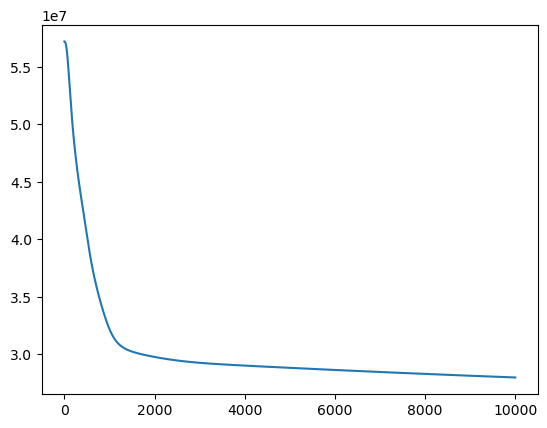

In [12]:
# # Burn-in period
# # Using an Adam Optimizer with lr = 0.1
dLearningRateBurnin = 1e-1
iBurnIn = 1e4
iEpochBurnin = 0
iEncodingDim = 2
ae_burnin = Autoencoder(iClaims, iEncodingDim, iOutputSize)
optimizer_burnin = torch.optim.Adam(ae_burnin.parameters(),
                             lr = dLearningRateBurnin)
criterion_burnin = torch.nn.MSELoss()

# TODO: Implement stopping criterion
lLoss = []
while iEpochBurnin < iBurnIn:
    tAEOutputs = ae_burnin(tOHETarget).reshape(tOHETarget.shape[0], 1, -1)
    loss_burnin = criterion_burnin(tAEOutputs.squeeze(), tInputEmbeddings.squeeze())
    lLoss.append(loss_burnin.item())
    optimizer_burnin.zero_grad()
    loss_burnin.backward(retain_graph=True)
    optimizer_burnin.step()
    iEpochBurnin += 1
    if iEpochBurnin % 100 == 0:
        print(f"Epoch {iEpochBurnin}, Loss: {loss_burnin.item()}")
    if loss_burnin.item() < 5e-2:
        break
        
plt.plot(lLoss)
plt.show()


In [13]:
print(f"Starting point of generation...\n\n")
tGenNew = fn_generate_max(ae_burnin(tOHETarget).reshape(tOHETarget.shape[0], 1, -1)).sequences
tGenData = fn_generate_max(tInputEmbeddings.reshape(tOHETarget.shape[0], 1, -1)).sequences
for i in range(tOHETarget.shape[0]):
    print(f"Claim {i}: {tokenizer.decode(tGenNew[i])}")
    #print(f"Claim {i}: {tokenizer.decode(tGenData[i])}")

Starting point of generation...


Claim 0: Rog shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 1: levels shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 2: Sel shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 3: Transform shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 4: TransformING that student student student student student student student student student student student student
Claim 5: Sel shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 6: Embracebracebracebrace the the the the in-inch the in-
Claim 7: Transform shine shine shine shine shine shine shine shine shine shine shine shine shine shine
Claim 8: Transform yourudesudesudesudesudesudesudesudes.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim 9: Transform://://://://://://://://://://://://://://
